# Bootstrapping

Bootstrapping is a statistical technique that allows us to access uncertainty about a certain point estimate. As far as we have seen in the course, whenever we wanted to calculate confidence intervals of an estimate, or calculate its standard errors, we would rely on asymptotic arguments. Those work well when we have large data sets. However, in small sample data sets, those arguments may be weaker and Boostrap methods can be useful. 

Bootstrapping consists in treating the sample we are using for point estimates as the population, so we can have access to uncertainty measures of the point estimates. In general, we would like to have confidence intervals or standard errors from some point estimate, say $\hat{\mu}$, calculated using our main sample of size $N$. To perform a bootstrap, we first have to resample our main sample $M$ times with replacement. For each of these new samples, we can calculate a new point estimate. That is, we will end up with a collection $\{\hat{\mu}^{(1)},\hat{\mu}^{(2)},\dots,\hat{\mu}^{(M)}\}$. This collection of estimates can be treated as a sample from the theoretical distribution of $\hat{\mu}$, so we can calculate it's percentiles to calculate our desired measures of uncertainty.

We can start simple by working with the simple average. Let's generate an i.i.d. sample and calculate the 5 samples average

\begin{equation*}

Y_i \sim U(0,1) 

\end{equation*}

\begin{equation*}

\mu_i = \frac{1}{2}
\quad
\sigma^2_{i} = \frac{1}{12}

\end{equation*}

\begin{equation*}

\bar{Y}=\sum_{i=1}^{5}\frac{Y_i}{5}

\end{equation*}



We can conduct a monte carlo experiment to know with high level of accuracy the small sample properties of this average.

In [9]:
import numpy as np 

N = 10

MC_reps = 100_000

Y_hat_MC = np.zeros(MC_reps)

for i in range(MC_reps):

    sample = np.random.rand(N) #selecciono un conjunto de datos
    Y_hat_MC[i] = np.mean(sample) #calculo media muestral, infinitamente

lower_bound_MC = np.percentile(Y_hat_MC, 2.5)
upper_bound_MC = np.percentile(Y_hat_MC, 97.5)

print(lower_bound_MC)
print(upper_bound_MC)

0.3225843705806102
0.678791805492364


Now, let's calculate the confidence intervals using asymptotic arguments. Let's take another sample from the distribution and calculate it's average

In [10]:
Y = np.random.rand(N)
Y_hat = np.mean(Y)

By the Central Limit Theorem for i.i.d. samples (Lindeberg-Lévy), the asymptotic distribution of the sample average is 

\begin{equation*}

\bar{Y} \overset{a}{\sim} N\left(\frac{1}{2},\frac{1}{12n}\right)

\end{equation*}

We can use scipy to calculate the 95% confidence interval around the mean

In [11]:
from scipy.stats import norm

lower_bound = norm.ppf(0.025, loc = 1/2, scale = np.sqrt(1/(12*N)))
upper_bound = norm.ppf(0.975, loc = 1/2, scale = np.sqrt(1/(12*N)))

In [12]:
print(lower_bound)
print(upper_bound)

0.32108058562828423
0.6789194143717157


If we had all the samples as the Montecarlo experiment, we would be able to approach the theoretical limit. However, we only have one sample and its related estimates. What are the bounds when we look at those?

In [13]:
Y_hat - 1.96 * Y.std(), Y_hat + 1.96 * Y.std()

(np.float64(-0.16806248377085514), np.float64(0.6465348721738091))

Now we get very imprecise bounds that span almost the entire distribution.

Now, let's calculate the confidence intervals using bootstrap

In [14]:
M = 100_000

Y_hat_boost = np.zeros(M)

for i in range(M):

    Y_boost = np.random.choice(Y, N, replace= True)

    Y_hat_boost[i] = np.mean(Y_boost)

lower_bound_boost = np.percentile(Y_hat_boost, 2.5)

upper_bound_boost = np.percentile(Y_hat_boost, 97.5)

print(lower_bound_boost)
print(upper_bound_boost)

0.11666044778976237
0.37261524883382907


In [15]:
delta = Y_hat_boost - Y_hat

lower_bound_hall = Y_hat - np.percentile(delta, 97.5)

upper_bound_hall = Y_hat - np.percentile(delta, 2.5)

print(lower_bound_hall)
print(upper_bound_hall)

0.10585713956912485
0.36181194061319155


The bootstrap result is fairly more accurate than the asymptotic argument.

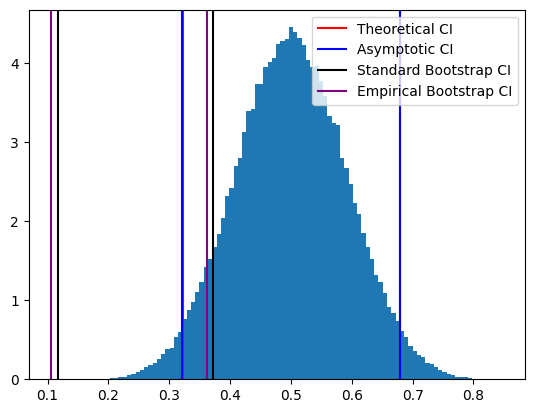

In [16]:
import matplotlib.pyplot as plt

hist_mc = plt.hist(Y_hat_MC, bins = 100 ,density= True)
plt.axvline(lower_bound_MC, color = 'red', label = 'Theoretical CI')
plt.axvline(upper_bound_MC, color = 'red')

plt.axvline(lower_bound, color = 'blue', label = 'Asymptotic CI')
plt.axvline(upper_bound, color = 'blue')

plt.axvline(lower_bound_boost, color = 'black', label = 'Standard Bootstrap CI')
plt.axvline(upper_bound_boost, color = 'black')

plt.axvline(lower_bound_hall, color = 'purple', label = 'Empirical Bootstrap CI')
plt.axvline(upper_bound_hall, color = 'purple')

plt.legend()

What about linear regression? We can perform the same task we did with the plain average. For simplicity, let's generate data from a bivariate linear regression:

\begin{equation*}

Y_i = 2+ 3 x_i + \varepsilon_i

\end{equation*}

\begin{equation*}

x_i \sim U(0,1)

\end{equation*}

\begin{equation*}

\varepsilon_i \sim N(0,1)
\end{equation*}

\begin{equation*}

\hat{\beta} = (X^\prime X)^{-1}(X^\prime Y)
\end{equation*}

In [17]:
beta_0 = 2
beta_1 = 3
x = np.random.uniform(0,1,N)

Then, we conduct the monte carlo experiment to know with high level of accuracy the small sample properties of this average

In [18]:
from sklearn.linear_model import LinearRegression

MC_reps = 100_000

beta_hat_MC = np.zeros((MC_reps,2))

for i in range(MC_reps):

    e_MC = np.random.normal(0,1,N)

    Y_MC = 2 + 3*x + e_MC

    model_MC = LinearRegression().fit(x.reshape(-1,1),Y_MC)

    beta_hat_MC[i,:] = np.hstack((model_MC.intercept_,model_MC.coef_))




In [19]:
lower_bound_b0_MC = np.percentile(beta_hat_MC[:,0], 2.5)
upper_bound_b0_MC = np.percentile(beta_hat_MC[:,0], 97.5)

lower_bound_b1_MC = np.percentile(beta_hat_MC[:,1], 2.5)
upper_bound_b1_MC = np.percentile(beta_hat_MC[:,1], 97.5)

print('b0')
print(lower_bound_b0_MC)
print(upper_bound_b0_MC)
print('--------------------')
print('b1')
print(lower_bound_b1_MC)
print(upper_bound_b1_MC)


b0
0.660183975319917
3.340809452542371
--------------------
b1
0.8304552459754212
5.167864992470065


Now, let's calculate the confidence intervals using asymptotic arguments. Let's take another sample from the DGP and estimate the coefficients

In [20]:
Y = 2 + 3*x + np.random.normal(0,1,N)
model_hat = LinearRegression().fit(x.reshape(-1,1),Y)
beta_hat = np.hstack((model_hat.intercept_,model_hat.coef_))

By the Central Limit Theorem for linear regression, the asymptotic distribution of the coefficients is

\begin{equation*}

\hat{\beta} \overset{a}{\sim} N\left(\beta,\sigma^2(X^\prime X)^{-1}\right)

\end{equation*}

Where

\begin{equation*}

\sigma^2 = 1

\end{equation*}

\begin{equation*}

\beta = (2,3)^\prime

\end{equation*}

In [21]:
X = np.array([np.ones(N),x]).T

cov_betas = np.linalg.inv(X.T@X)

lower_bound_b0 = norm.ppf(0.025, loc = beta_0, scale = np.sqrt(cov_betas[0,0]))
upper_bound_b0 = norm.ppf(0.975, loc = beta_0, scale = np.sqrt(cov_betas[0,0]))

lower_bound_b1 = norm.ppf(0.025, loc = beta_1, scale = np.sqrt(cov_betas[1,1]))
upper_bound_b1 = norm.ppf(0.975, loc = beta_1, scale = np.sqrt(cov_betas[1,1]))

In [22]:
print('b0 ols')
print(lower_bound_b0)
print(upper_bound_b0)
print('--------------------')
print('b1 ols')
print(lower_bound_b1)
print(upper_bound_b1)

b0 ols
0.6590877877664241
3.340912212233576
--------------------
b1 ols
0.821510014166122
5.1784899858338775


To perform a bootstrap for linear regression, there exist at least four methods: empirical/paired bootstrap, residual based bootstrap, wild bootstrap and block bootstrap . The first and second methods are the most commonly used when the basic assumptions of OLS hold (Gauss-Markov theorem). The third and four methods tackle the issues arising from heteroskedasticity and serial correlation. We will stick with the first approach due to it's similarity with the simple average procedure.

In [23]:
# Residual based approach

e = Y - (beta_hat[0]+beta_hat[1]*x)

M = 100_000

beta_hat_boost = np.zeros((M,2))

for i in range(M):

    Y_boost = beta_hat[0]+beta_hat[1]*x + np.random.choice(e, N, replace= True)

    model_boost = LinearRegression().fit(x.reshape(-1,1),Y_boost)

    beta_hat_boost[i,:] = np.hstack((model_boost.intercept_,model_boost.coef_))

lower_bound_b0_boost = np.percentile(beta_hat_boost[:,0], 2.5)
upper_bound_b0_boost = np.percentile(beta_hat_boost[:,0], 97.5)

lower_bound_b1_boost = np.percentile(beta_hat_boost[:,1], 2.5)
upper_bound_b1_boost = np.percentile(beta_hat_boost[:,1], 97.5)

print('b0 simple bootstrap')
print(lower_bound_b0_boost)
print(upper_bound_b0_boost)
print('--------------------')
print('b1 simple bootstrap')
print(lower_bound_b1_boost)
print(upper_bound_b1_boost)

b0 simple bootstrap
1.7152575441770317
4.1428686004525
--------------------
b1 simple bootstrap
0.8734973254915538
4.837662616053706


In [25]:
M = 100_000

beta_hat_boost = np.zeros((M,2))

for i in range(M):

     Z = np.hstack((x.reshape(-1,1),Y.reshape(-1,1)))

     random_index = np.random.choice(N,N,replace= True)

     Z_boost = Z[random_index]

     model_boost = LinearRegression().fit(Z_boost[:,0:1],Z_boost[:,1])

     beta_hat_boost[i,:] = np.hstack((model_boost.intercept_,model_boost.coef_))

lower_bound_b0_boost = np.percentile(beta_hat_boost[:,0], 2.5)
upper_bound_b0_boost = np.percentile(beta_hat_boost[:,0], 97.5)

lower_bound_b1_boost = np.percentile(beta_hat_boost[:,1], 2.5)
upper_bound_b1_boost = np.percentile(beta_hat_boost[:,1], 97.5)

print('b0 simple bootstrap')
print(lower_bound_b0_boost)
print(upper_bound_b0_boost)
print('--------------------')
print('b1 simple bootstrap')
print(lower_bound_b1_boost)
print(upper_bound_b1_boost)

b0 simple bootstrap
1.9483078568452457
4.959590765654662
--------------------
b1 simple bootstrap
-0.1482281835766903
5.425313534361073


In [17]:
delta_b0 = beta_hat_boost[:,0] - beta_hat[0]
delta_b1 = beta_hat_boost[:,1] - beta_hat[1]

lower_bound_b0_hall = beta_hat[0] - np.percentile(delta_b0, 97.5)
upper_bound_b0_hall = beta_hat[0] - np.percentile(delta_b0, 2.5)

lower_bound_b1_hall = beta_hat[1] - np.percentile(delta_b1, 97.5)
upper_bound_b1_hall = beta_hat[1] - np.percentile(delta_b1, 2.5)

In [18]:
print('b0 empirical bootstrap')
print(lower_bound_b0_hall)
print(upper_bound_b0_hall)
print('--------------------')
print('b1 empirical bootstrap')
print(lower_bound_b1_hall)
print(upper_bound_b1_hall)

b0 empirical bootstrap
1.42239543168222
2.959228419560054
--------------------
b1 empirical bootstrap
1.35377648846943
3.8186502608073485


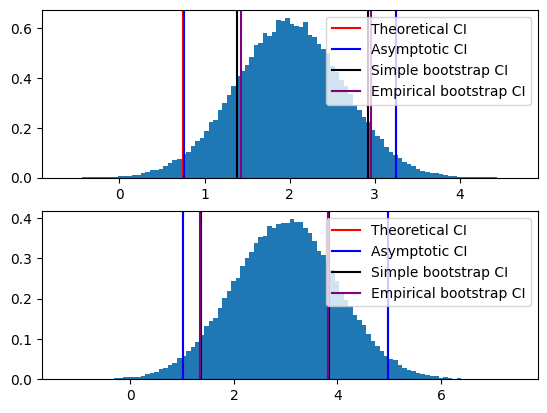

In [19]:
fig, ax = plt.subplots(2,1)

hist_b0 = ax[0].hist(beta_hat_MC[:,0], bins = 100 ,density= True)

ax[0].axvline(lower_bound_b0_MC, color = 'red', label = 'Theoretical CI')
ax[0].axvline(upper_bound_b0_MC, color = 'red')

ax[0].axvline(lower_bound_b0, color = 'blue', label = 'Asymptotic CI')
ax[0].axvline(upper_bound_b0, color = 'blue')

ax[0].axvline(lower_bound_b0_boost, color = 'black', label = 'Simple bootstrap CI')
ax[0].axvline(upper_bound_b0_boost, color = 'black')

ax[0].axvline(lower_bound_b0_hall, color = 'purple', label = 'Empirical bootstrap CI')
ax[0].axvline(upper_bound_b0_hall, color = 'purple')


hist_b1 = ax[1].hist(beta_hat_MC[:,1], bins = 100 ,density= True)

ax[1].axvline(lower_bound_b1_MC, color = 'red', label = 'Theoretical CI')
ax[1].axvline(upper_bound_b1_MC, color = 'red')

ax[1].axvline(lower_bound_b1, color = 'blue', label = 'Asymptotic CI')
ax[1].axvline(upper_bound_b1, color = 'blue')

ax[1].axvline(lower_bound_b1_boost, color = 'black', label = 'Simple bootstrap CI')
ax[1].axvline(upper_bound_b1_boost, color = 'black')

ax[1].axvline(lower_bound_b1_hall, color = 'purple', label = 'Empirical bootstrap CI')
ax[1].axvline(upper_bound_b1_hall, color = 'purple')

ax[0].legend()
ax[1].legend()
